### Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. 
### Оценить качество и прислать соображения почему была выбрана та или иная модель

In [604]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [214]:
auto_registration = pd.read_csv("monthly-us-auto-registration-tho.csv",sep=';')

In [215]:
auto_registration=auto_registration.iloc[:,1]

In [216]:
def test_stationarity(timeseries,print_type='all'):
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    if print_type=='all':
        print('Results of Dickey-Fuller Test:')
        print(dfoutput)
    else: 
        return dfoutput['p-value']
    
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    majorLocator = MultipleLocator(20)
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator(5)
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
        #ts_ax.xaxis.set_major_locator(majorLocator)
        #ts_ax.xaxis.set_major_formatter(majorFormatter)
        ts_ax.tick_params(which='minor', length=7, color='r')
# for the minor ticks, use no labels; default NullFormatter
        ts_ax.xaxis.set_minor_locator(minorLocator)
    return

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


/home/gavril/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


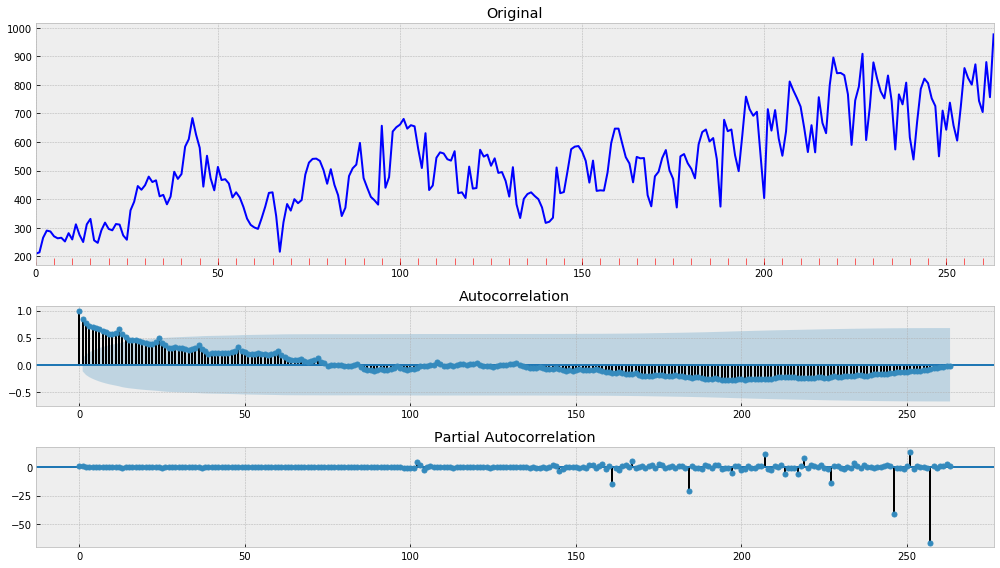

In [217]:
tsplot(auto_registration)

#### Ok, Имеем нестационарный ряд
#### Снизим с помомощью преобразования Бокса-Кокса его дисперсию

In [537]:
series=auto_registration

Results of Dickey-Fuller Test:
Test Statistic                  -1.941628
p-value                          0.312738
#Lags Used                      14.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


/home/gavril/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


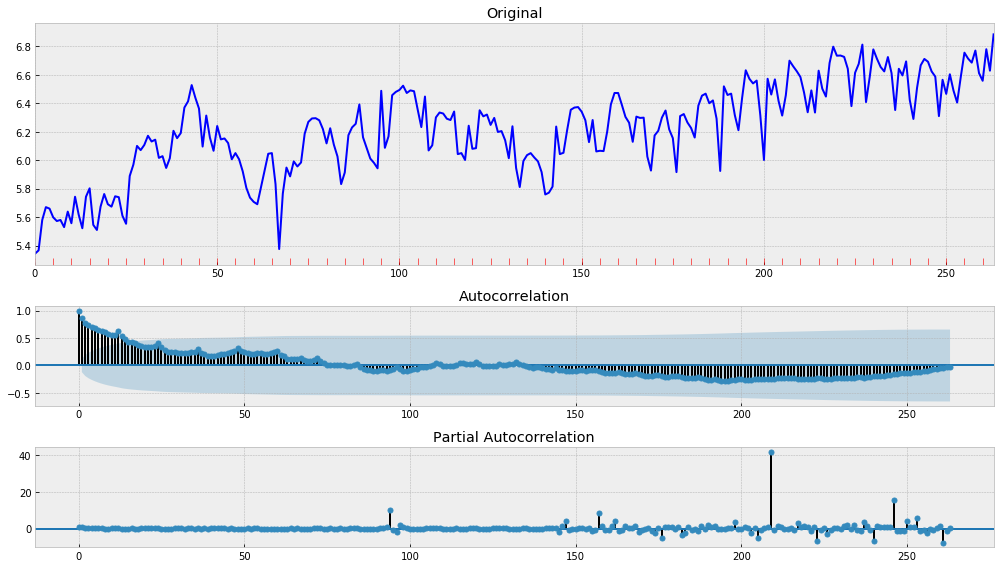

In [538]:
series=boxcox(series,0)
tsplot(series)

In [539]:
series.shape

(264,)

#### MA

In [540]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

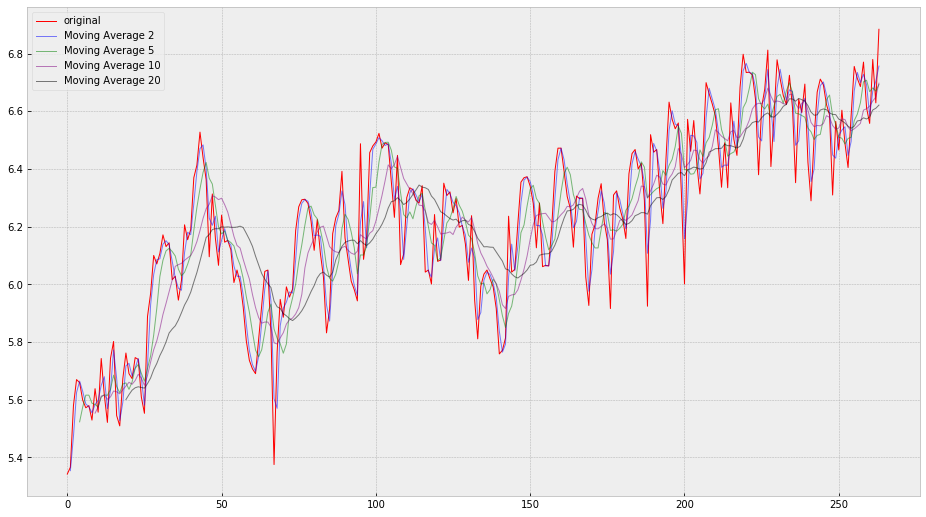

In [541]:
windows = [2,5,10,20]
colors = ['blue', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 9))
    plt.plot(series, color='red',label='original', linewidth='1')
    for i in range(len(windows)):
        ser = moving_average(series, windows[i])
        plt.plot(ser, color=colors[i], linewidth='1', alpha=0.5, label='Moving Average {}'.format(windows[i]))
    plt.legend()

* видно, что лучше всего веедет себя ряд с большим окном, однако дисперсию оригинального ряда он воспроизвести не может

#### WMA

In [542]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [543]:

wma_fib = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
wma_seq = weighted_moving_average(series, 7, [1,2,3,4,5,6,7])
wma_pow = weighted_moving_average(series, 7, [1,2,4,8,16,32,64])

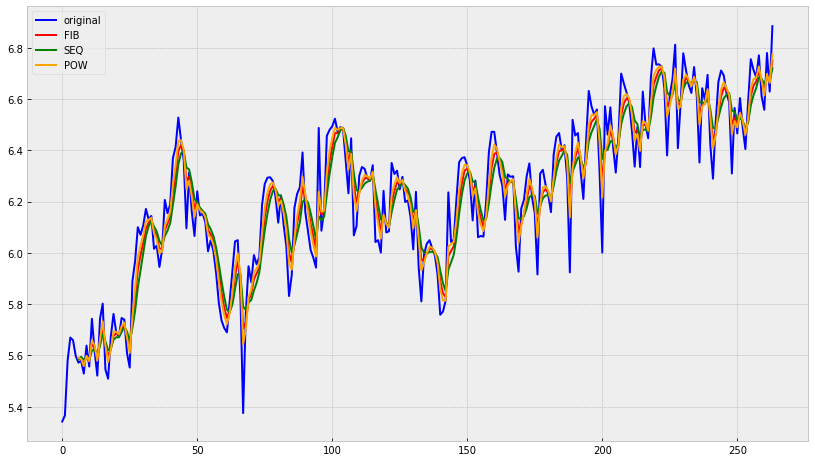

In [544]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    
    plt.plot(wma_fib, color='red', linewidth='2', label='FIB')
    plt.plot(wma_seq, color='green', linewidth='2', label='SEQ')
    plt.plot(wma_pow, color='orange', linewidth='2', label='POW')
    plt.legend()

* В целом также неплохо скользящие неплохо описывают , однако плохо ловят экстремумы

#### EMA

In [545]:
train, val = series[:230], series[230:]

In [593]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

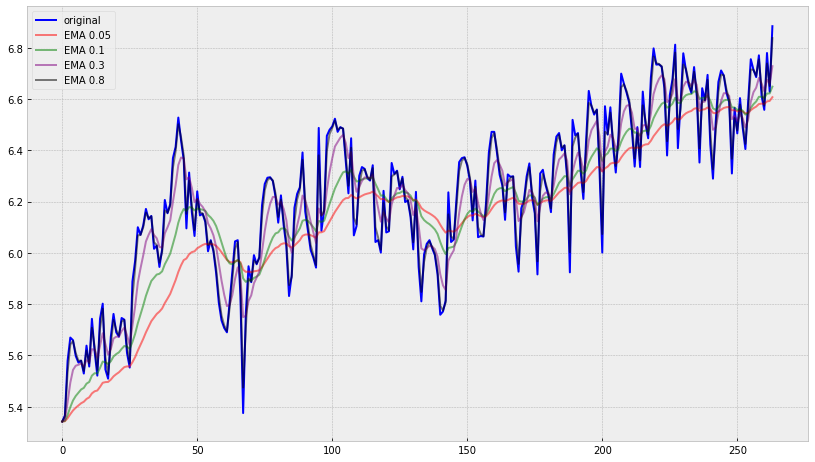

In [547]:

alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(series, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', alpha=0.5, label='EMA {}'.format(alphas[i]))
    plt.legend()

* видно, что чем больше мы -опираемся на ближайшее набюлдение, тем точнее прдсказываем

#### Попрбуем подобрать Лучшую alpha

In [548]:
def mse_cross_val(X):
    alpha= X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = exponential_moving_average(train[train_split],  alpha)
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, train[test_split])
        errors.append(error)
        #print(error)
    return np.mean(np.array(errors))

In [549]:
opt = minimize(mse_cross_val, x0=[0], method="L-BFGS-B", bounds = ((0, 1),))

In [550]:
alpha_opt= opt.x
print(opt)

      fun: 0.09395857811845026
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.3869795e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 34
      nit: 8
   status: 0
  success: True
        x: array([0.26066636])


In [551]:
def exponential_moving_average(series, alpha, n_pred=None):
    series=pd.DataFrame(train)[0]
    result = [series[0]]
    print(result)
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

[5.342334251964811]


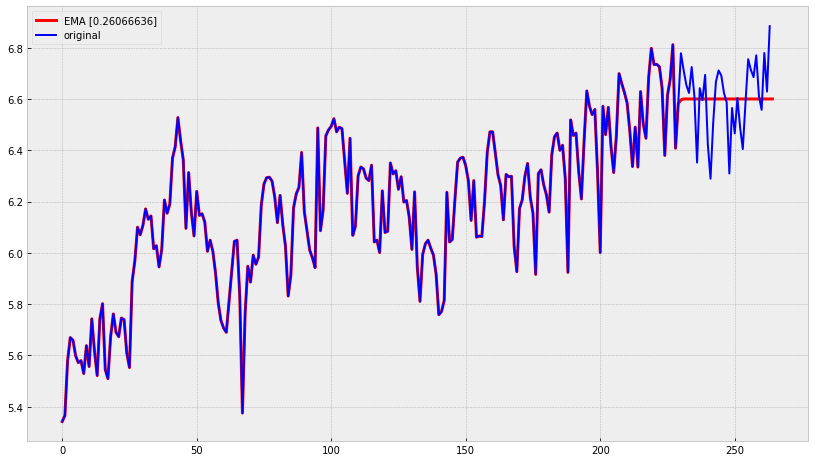

In [552]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    
    ser, _ = exponential_moving_average(train, alpha_opt, len(val))
    plt.plot(ser, color='red', linewidth='3', label='EMA {}'.format(alpha_opt))
    plt.plot(series, color='blue',label='original')
    plt.legend()

* видно, что оч быстро затухает диисперсия

#### DEMA

In [553]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

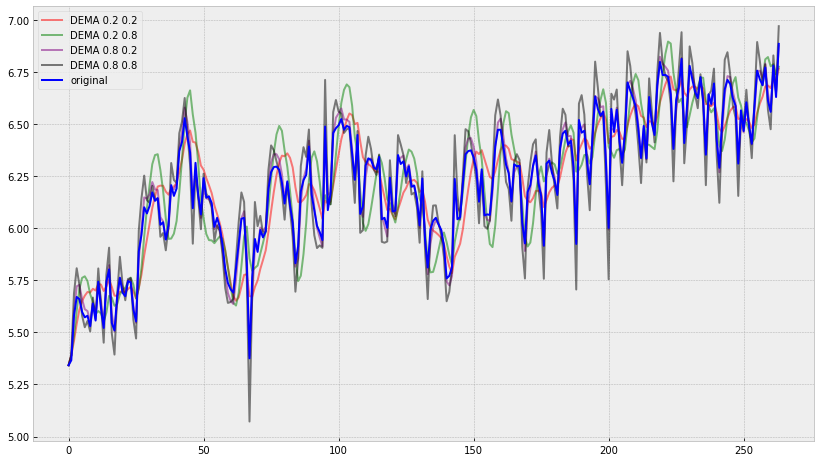

In [554]:

alphas = [0.2,0.2,0.8,0.8]
bettas = [0.2,0.8,0.2,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser = double_ema(series, alphas[i], bettas[i])
        plt.plot(ser, color=colors[i], linewidth='2', alpha=0.5, label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

* здесь видно насколько чувствительна DEMA у параметрам

In [555]:
def mse_cross_val(X):
    alpha, beta= X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = double_ema(train[train_split],  alpha, beta)
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, train[test_split])
        errors.append(error)
        #print(error)
    return np.mean(np.array(errors))

In [556]:
opt = minimize(mse_cross_val, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [557]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 0.057623723896326744
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.41233725e-08,  3.91970639e-01])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 69
      nit: 8
   status: 0
  success: True
        x: array([0.12051628, 0.        ])


In [558]:
def plot_dema(alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [563]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    series=pd.DataFrame(train)[0]
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

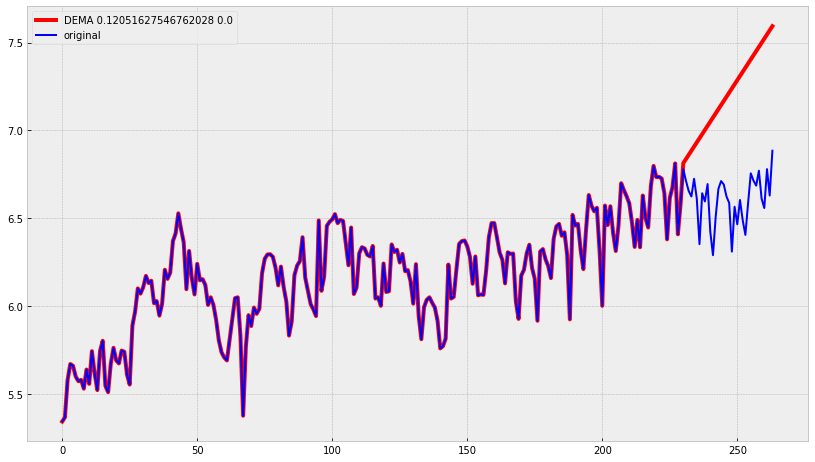

In [564]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    ser, _ = double_ema_with_preds(train, alpha_opt, beta_opt, len(val))
    plt.plot(ser, color='red', linewidth='4', label='DEMA {} {}'.format(alpha_opt, beta_opt))
    plt.plot(series, color='blue',label='original')
    plt.legend()

* все оч плохо -пррогноз улетел куда-то в небеса

#### TEMA

In [565]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

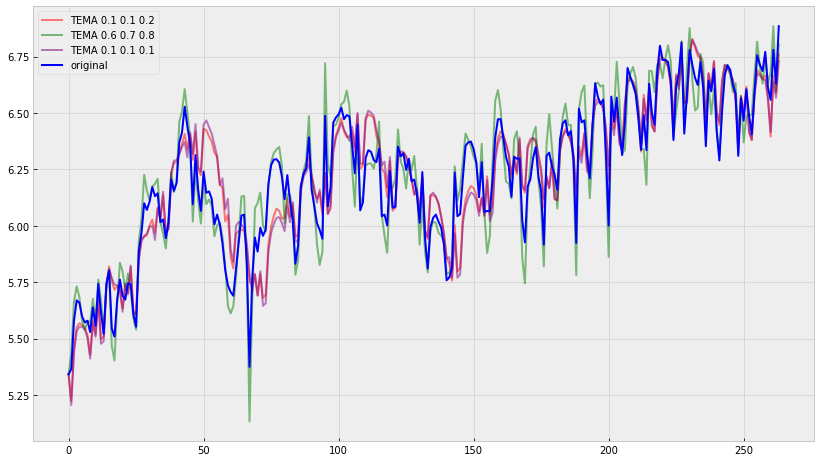

In [566]:
alphas = [0.1,0.6,0.1]
bettas = [0.1,0.7,0.1]
gammas = [0.2,0.8,0.1]
colors = ['red', 'green', 'purple', 'black']

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser = triple_exponential_smoothing(series, 12, alphas[i], bettas[i], gammas[i],  0)
        plt.plot(ser, color=colors[i], linewidth='2', alpha=0.5, label='TEMA {} {} {}'.format(alphas[i], bettas[i], gammas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

In [568]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA', alpha=0.5)
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [569]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [570]:
train, val = series[:214], series[214:]

In [571]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [572]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 9.541212177061217e-09
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.92623462e-06, -5.26100553e-06,  1.38330553e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 296
      nit: 55
   status: 0
  success: True
        x: array([0.05348753, 0.22920087, 0.93721235])


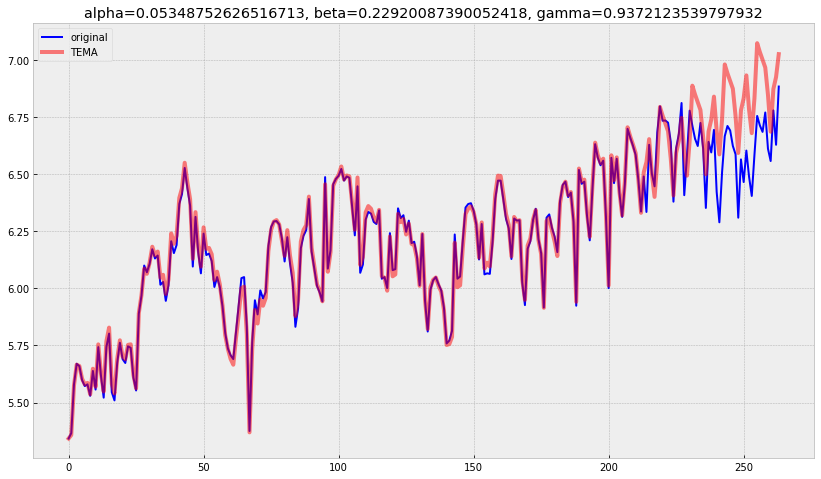

In [573]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

* TEMA  хороша поймала секзонные колебания, но явно переобучилась поймав тренд 

### Попробуем привести этот же ря к стаицонарному состоянию:

Results of Dickey-Fuller Test:
Test Statistic                  -4.362471
p-value                          0.000346
#Lags Used                      14.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


/home/gavril/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


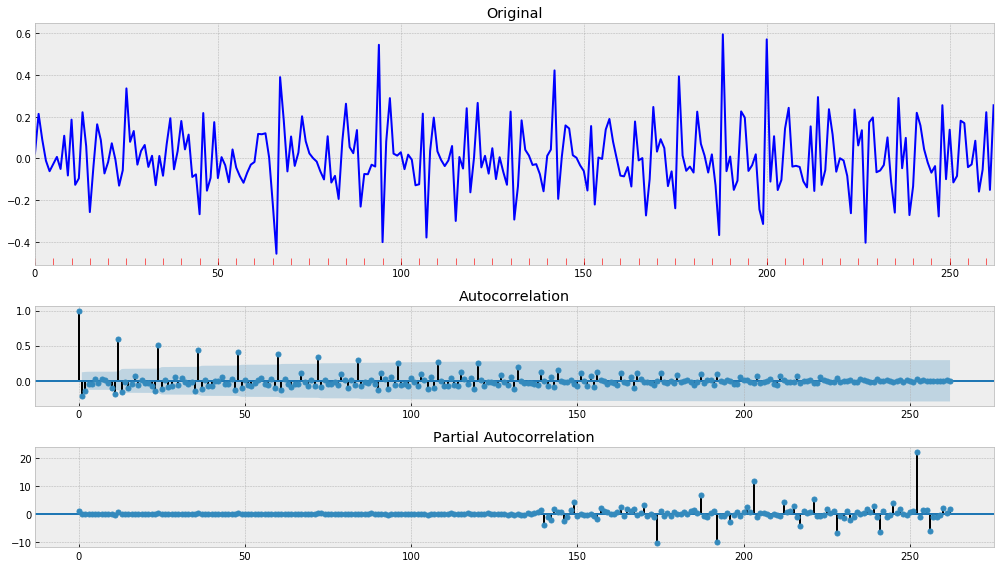

In [440]:
auto_registration_box_cox_0_diff_1=np.diff( series, 1)
tsplot(auto_registration_box_cox_0_diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -6.528275e+00
p-value                        1.001817e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


/home/gavril/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


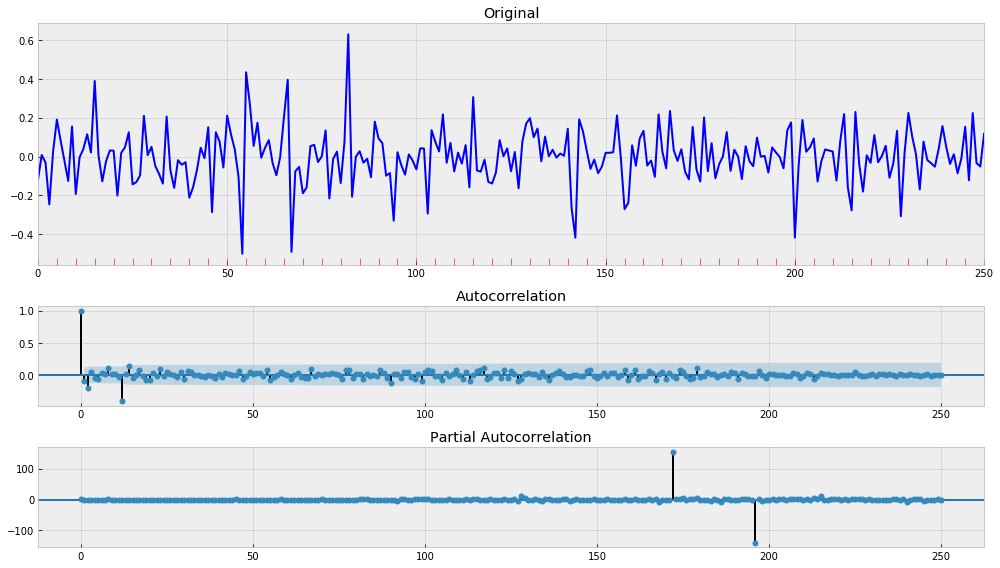

In [444]:
h=12
auto_registration_box_cox_0_diff_1_no_season = auto_registration_box_cox_0_diff_1[h:] - auto_registration_box_cox_0_diff_1[:-h]
tsplot(auto_registration_box_cox_0_diff_1_no_season)

* Ну более менее похоже- DF-test pvalue<0.05, график авткоореляции в целом в доверительном интревале, график частичной автокоорялиции показыавет 2 отделбных выброса

In [575]:
series=auto_registration_box_cox_0_diff_1_no_season

In [576]:
train, val = series[:210], series[210:]

In [577]:
series.shape

(251,)

#### EMA

In [591]:
def mse_cross_val(X):
    alpha= X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = exponential_moving_average(train[train_split],  alpha)
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, train[test_split])
        errors.append(error)
        #print(error)
    return np.mean(np.array(errors))

In [594]:
opt = minimize(mse_cross_val, x0=[0], method="L-BFGS-B", bounds = ((0, 1),))

In [595]:
alpha_opt= opt.x
print(opt)

      fun: 0.023472326309388464
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.05530037e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 8
   status: 0
  success: True
        x: array([0.0748495])


In [596]:
def exponential_moving_average(series, alpha, n_pred=None):
    series=pd.DataFrame(train)[0]
    result = [series[0]]
    print(result)
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

[-0.1189519428613659]


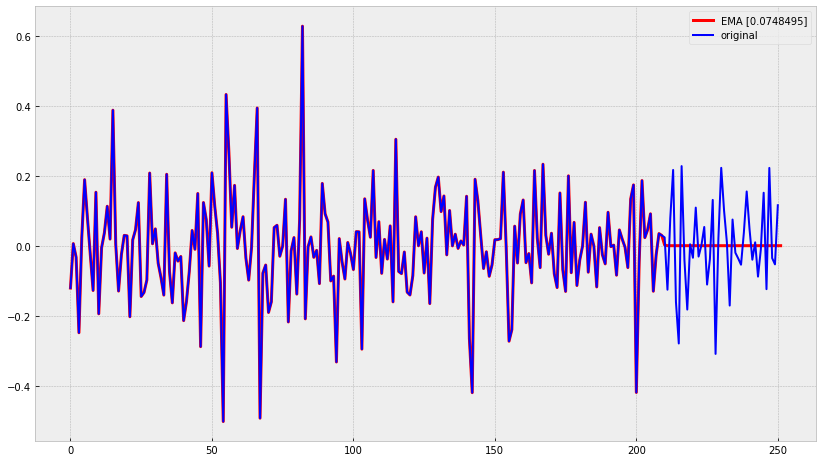

In [597]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    
    ser, _ = exponential_moving_average(train, alpha_opt, len(val))
    plt.plot(ser, color='red', linewidth='3', label='EMA {}'.format(alpha_opt))
    plt.plot(series, color='blue',label='original')
    plt.legend()

* видно, что оч быстро затухает диисперсия

#### DEMA

In [598]:
def mse_cross_val(X):
    alpha, beta= X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = double_ema(train[train_split],  alpha, beta)
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, train[test_split])
        errors.append(error)
        #print(error)
    return np.mean(np.array(errors))

In [599]:
opt = minimize(mse_cross_val, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [600]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 0.028233206811947947
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.28070904e-06, -3.43614026e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 72
      nit: 21
   status: 0
  success: True
        x: array([0.24169875, 0.2804138 ])


In [601]:
def plot_dema(alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [602]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    series=pd.DataFrame(train)[0]
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

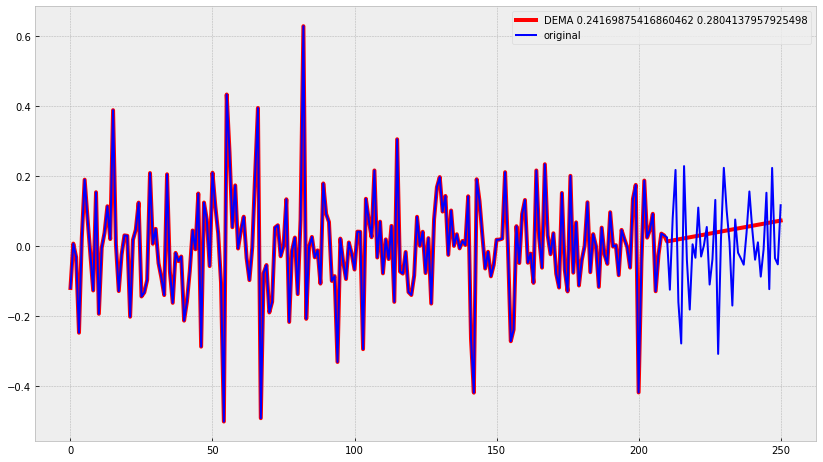

In [603]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    ser, _ = double_ema_with_preds(train, alpha_opt, beta_opt, len(val))
    plt.plot(ser, color='red', linewidth='4', label='DEMA {} {}'.format(alpha_opt, beta_opt))
    plt.plot(series, color='blue',label='original')
    plt.legend()

* здесь дисперсия так же быстро затухает, моделька поймала тренд, вопрос куда он может нас завести только

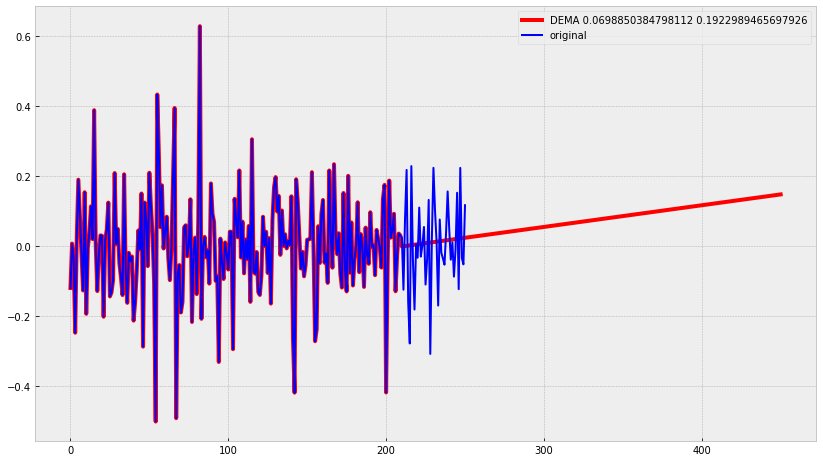

In [610]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    ser, _ = double_ema_with_preds(train, alpha_opt, beta_opt, len(val)+200)
    plt.plot(ser, color='red', linewidth='4', label='DEMA {} {}'.format(alpha_opt, beta_opt))
    plt.plot(series, color='blue',label='original')
    plt.legend()

* хотя бы в космос не стремится как в нестационарном варианте

#### TEMA

In [605]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [606]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [607]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 6.612523743877666e-08
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.27901075e-06, -4.59924989e-06, -4.03056866e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 196
      nit: 34
   status: 0
  success: True
        x: array([0.06988504, 0.19229895, 0.921658  ])


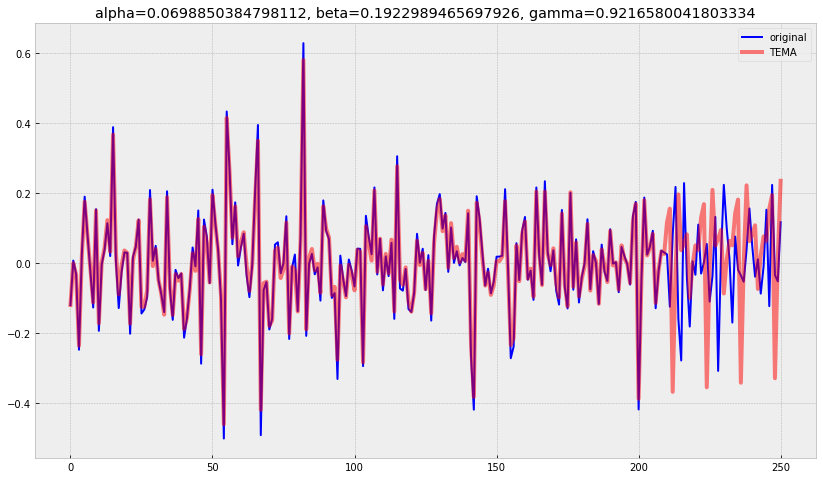

In [608]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

* ну может быть здесь и получше , но есть  другая проблема, по сравнению с нестационарным вариантом, - сильно отличается ддиспесия
* Прогнозировать стационарный  ряд лучше, чем прогнозировать нестационарный ряд
* В целом я не решился бы назавать прогноз даваемый моедлями класса MA достоверным